In [ ]:

from pyspark import SparkContext, SparkConf

conf = SparkConf().setMaster("local[*]").setAppName("heart-disease-prediction-descision-tree")
sc   = SparkContext(conf=conf)



In [1]:
print "Running Spark Version %s" % (sc.version)

Running Spark Version 2.0.0


In [2]:
import pandas as pd
import numpy as np


heartdf = pd.read_csv("processed.cleveland.data",header=None)

print "Original Dataset (Rows:Colums): "
print heartdf.shape
heartdf.head()

Original Dataset (Rows:Colums): 
(303, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
print "Categories of Diagnosis of heart disease (angiographic disease status) that we are predicting"
print "-- Value 0: < 50% diameter narrowing"
print "-- Value 1: > 50% diameter narrowing "
print heartdf.ix[:,13].unique() #Column containing the Diagnosis of heart disease


Categories of Diagnosis of heart disease (angiographic disease status) that we are predicting
-- Value 0: < 50% diameter narrowing
-- Value 1: > 50% diameter narrowing 
[0 2 1 3 4]


In [4]:
newheartdf = pd.concat([heartdf.ix[:,13], heartdf.ix[:,0:12]],axis=1, join_axes=[heartdf.index])
newheartdf.replace('?', np.nan, inplace=True) # Replace ? values

newheartdf.head()

,13,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,2,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,0,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,0,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [5]:
print
print "After dropping rows with anyone empty value (Rows:Columns): "
ndf2 = newheartdf.dropna()
ndf2.to_csv("heart-disease-cleaveland.txt",sep=",",index=False,header=None,na_rep=np.nan)
print ndf2.shape
print ndf2.ix[:5,:]



After dropping rows with anyone empty value (Rows:Columns): 
(297, 14)
   13    0    1    2      3      4    5    6      7    8    9    10   11   12
0   0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0
1   2  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0
2   1  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0
3   0  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0
4   0  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0
5   0  56.0  1.0  2.0  120.0  236.0  0.0  0.0  178.0  0.0  0.8  1.0  0.0  3.0


In [6]:
from pyspark.mllib.regression import LabeledPoint

points = sc.textFile('heart-disease-cleaveland.txt') 

def parsePoint(line):
    """
    Parse a line of text into an MLlib LabeledPoint object.
    """
    values = [float(s) for s in line.strip().split(',')]
    if values[0] == -1: # Convert -1 labels to 0 for MLlib
        values[0] = 0
    elif values[0] > 0:
        values[0] = 1
    return LabeledPoint(values[0], values[1:])

parsed_data = points.map(parsePoint)

print 'After parsing, number of training lines: %s' % parsed_data.count()

parsed_data.take(5)

After parsing, number of training lines: 297


[LabeledPoint(0.0, [63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0]),
 LabeledPoint(1.0, [67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0]),
 LabeledPoint(1.0, [67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0]),
 LabeledPoint(0.0, [37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0]),
 LabeledPoint(0.0, [41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0])]

In [7]:
from pyspark.mllib.tree import DecisionTree
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = parsed_data.randomSplit([0.7, 0.3],seed=1234)
# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainClassifier(trainingData, numClasses=5, categoricalFeaturesInfo={}, impurity='gini', maxDepth=3, maxBins=32)


In [8]:
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testData.count())
print('Test Error = ' + str(testErr))

Test Error = 0.176470588235


## Learned Classification Tree Created by the Model

In [9]:
print(model.toDebugString())

DecisionTreeModel classifier of depth 3 with 15 nodes
  If (feature 12 <= 3.0)
   If (feature 11 <= 0.0)
    If (feature 0 <= 57.0)
     Predict: 0.0
    Else (feature 0 > 57.0)
     Predict: 0.0
   Else (feature 11 > 0.0)
    If (feature 2 <= 3.0)
     Predict: 0.0
    Else (feature 2 > 3.0)
     Predict: 1.0
  Else (feature 12 > 3.0)
   If (feature 2 <= 3.0)
    If (feature 11 <= 0.0)
     Predict: 0.0
    Else (feature 11 > 0.0)
     Predict: 1.0
   Else (feature 2 > 3.0)
    If (feature 3 <= 108.0)
     Predict: 0.0
    Else (feature 3 > 108.0)
     Predict: 1.0



In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(labelsAndPredictions)

## Accuracy of the Model

In [11]:
print "Accuracy of the model on test set: "+str(metrics.accuracy)

Accuracy of the model on test set: 0.823529411765


## Confusion Matrix

In [13]:
cnfm = metrics.confusionMatrix().toArray()
cnfm

array([[ 35.,   9.],
       [  6.,  35.]])

## Precision and Recall of the model

In [14]:
print "Precision: "+str(metrics.weightedPrecision)
print "Recall: "+str(metrics.weightedRecall)

Precision: 0.825583670275
Recall: 0.823529411765


## Regression

In [15]:
modelr = DecisionTree.trainRegressor(trainingData, categoricalFeaturesInfo={}, impurity='variance', maxDepth=3, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = modelr.predict(testData.map(lambda x: x.features))
labelsAndPredictionsR = testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictionsR.map(lambda (v, p): (v - p) * (v - p)).sum() / float(testData.count())
print('Test Mean Squared Error = ' + str(testMSE))


Test Mean Squared Error = 0.149777874244


## Decision Tree for Regression

In [16]:
print('Learned regression tree model:')
print(modelr.toDebugString())

Learned regression tree model:
DecisionTreeModel regressor of depth 3 with 15 nodes
  If (feature 12 <= 3.0)
   If (feature 11 <= 0.0)
    If (feature 0 <= 57.0)
     Predict: 0.01639344262295082
    Else (feature 0 > 57.0)
     Predict: 0.2962962962962963
   Else (feature 11 > 0.0)
    If (feature 2 <= 3.0)
     Predict: 0.25
    Else (feature 2 > 3.0)
     Predict: 0.8461538461538461
  Else (feature 12 > 3.0)
   If (feature 2 <= 3.0)
    If (feature 11 <= 0.0)
     Predict: 0.3
    Else (feature 11 > 0.0)
     Predict: 0.7272727272727273
   Else (feature 2 > 3.0)
    If (feature 3 <= 108.0)
     Predict: 0.0
    Else (feature 3 > 108.0)
     Predict: 0.9152542372881356



In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

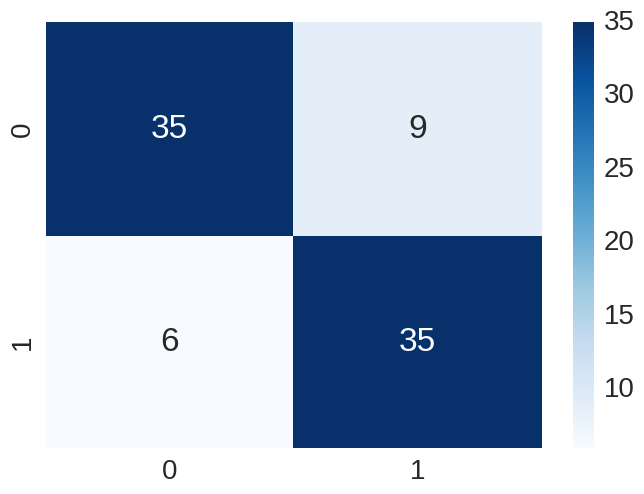

In [26]:
#plt.figsize((8,8))
sns.set(rc={"figure.figsize": (6, 6)})
sns.set(font_scale=2)
sns.heatmap(cnfm,annot=True,cmap='Blues')